##### Approach - A Random Forest can be built with target variable Sales (we will first convert it in categorical variable) & all other variable will be independent in the analysis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
comp = pd.read_csv("Downloads/Company_Data.csv")
comp.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### EDA

In [3]:
comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


In [4]:
comp.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [5]:
comp[comp.duplicated()].shape

(0, 11)

In [6]:
comp.describe().T

,count,mean,std,min,25%,50%,75%,max
Sales,400.0,7.496325,2.824115,0.0,5.39,7.49,9.32,16.27
CompPrice,400.0,124.975000,15.334512,77.0,115.00,125.00,135.00,175.00
Income,400.0,68.657500,27.986037,21.0,42.75,69.00,91.00,120.00
Advertising,400.0,6.635000,6.650364,0.0,0.00,5.00,12.00,29.00
Population,400.0,264.840000,147.376436,10.0,139.00,272.00,398.50,509.00
Price,400.0,115.795000,23.676664,24.0,100.00,117.00,131.00,191.00
Age,400.0,53.322500,16.200297,25.0,39.75,54.50,66.00,80.00
Education,400.0,13.900000,2.620528,10.0,12.00,14.00,16.00,18.00


### Outlier Check

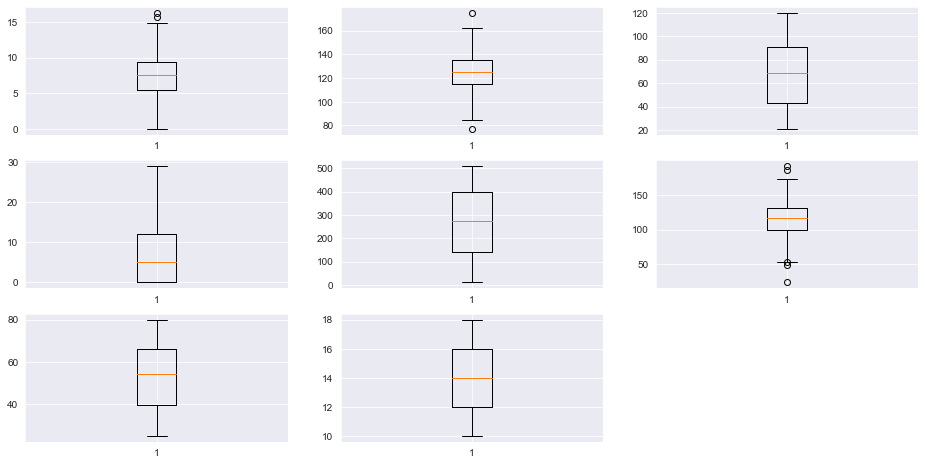

In [7]:
import warnings
sns.set_style(style='darkgrid')
plt.figure(figsize=(16,8))

plt.subplot(331)
plt.boxplot(comp["Sales"])

plt.subplot(332)
plt.boxplot(comp["CompPrice"])

plt.subplot(333)
plt.boxplot(comp["Income"])

plt.subplot(334)
plt.boxplot(comp["Advertising"])

plt.subplot(335)
plt.boxplot(comp["Population"])

plt.subplot(336)
plt.boxplot(comp["Price"])

plt.subplot(337)
plt.boxplot(comp["Age"])

plt.subplot(338)
plt.boxplot(comp["Education"])
plt.show()

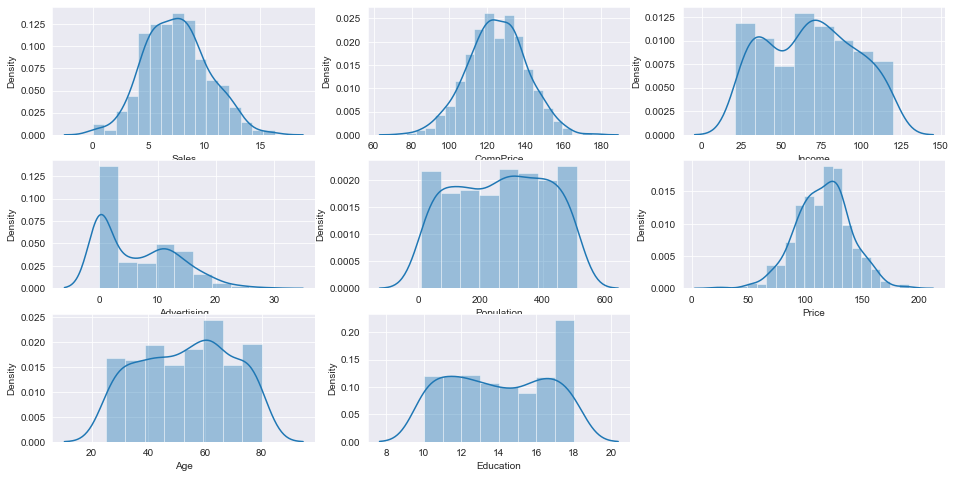

In [8]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style(style='darkgrid')
plt.figure(figsize=(16,8))

plt.subplot(331)
sns.distplot(comp["Sales"])

plt.subplot(332)
sns.distplot(comp["CompPrice"])

plt.subplot(333)
sns.distplot(comp["Income"])

plt.subplot(334)
sns.distplot(comp["Advertising"])

plt.subplot(335)
sns.distplot(comp["Population"])

plt.subplot(336)
sns.distplot(comp["Price"])

plt.subplot(337)
sns.distplot(comp["Age"])

plt.subplot(338)
sns.distplot(comp["Education"])
plt.show()

In [9]:
comp_1 = pd.get_dummies(comp, columns=["ShelveLoc", "Urban", "US"], drop_first=True)
comp_1.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,0,0,1,1
1,11.22,111,48,16,260,83,65,10,1,0,1,1
2,10.06,113,35,10,269,80,59,12,0,1,1,1
3,7.40,117,100,4,466,97,55,14,0,1,1,1
4,4.15,141,64,3,340,128,38,13,0,0,1,0


### Since the target variable is continious, we create a class of the value based on the mean

In [10]:
print({"Mean":comp_1["Sales"].mean(), "Min":comp_1["Sales"].min(), "Max":comp_1["Sales"].max()})

{'Mean': 7.496325, 'Min': 0.0, 'Max': 16.27}


#### Let's assume:

In [11]:
comp_1["sales"] = pd.cut(comp_1["Sales"], bins=[0, 7.49, 16.27], labels=["Low_Sale","High_Sale"])
comp_1.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,sales
0,9.50,138,73,11,276,120,42,17,0,0,1,1,High_Sale
1,11.22,111,48,16,260,83,65,10,1,0,1,1,High_Sale
2,10.06,113,35,10,269,80,59,12,0,1,1,1,High_Sale
3,7.40,117,100,4,466,97,55,14,0,1,1,1,Low_Sale
4,4.15,141,64,3,340,128,38,13,0,0,1,0,Low_Sale


In [12]:
comp_2 = pd.get_dummies(comp_1.iloc[:,1:], columns=["sales"], drop_first=True)
comp_2.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,sales_High_Sale
0,138,73,11,276,120,42,17,0,0,1,1,1
1,111,48,16,260,83,65,10,1,0,1,1,1
2,113,35,10,269,80,59,12,0,1,1,1,1
3,117,100,4,466,97,55,14,0,1,1,1,0
4,141,64,3,340,128,38,13,0,0,1,0,0


In [13]:
comp_2.corr()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,sales_High_Sale
CompPrice,1.000000,-0.080653,-0.024199,-0.094707,0.584848,-0.100239,0.025197,0.026386,0.008683,0.066594,0.016869,0.035578
Income,-0.080653,1.000000,0.058995,-0.007877,-0.056698,-0.004670,-0.056855,-0.012657,-0.051392,0.037967,0.089601,0.123460
Advertising,-0.024199,0.058995,1.000000,0.265652,0.044537,-0.004557,-0.033594,0.056149,-0.015929,0.042035,0.684460,0.251910
Population,-0.094707,-0.007877,0.265652,1.000000,-0.012144,-0.042663,-0.106378,0.007789,-0.040640,-0.052025,0.060564,0.069327
Price,0.584848,-0.056698,0.044537,-0.012144,1.000000,-0.102177,0.011747,0.045854,-0.006607,0.047016,0.057861,-0.392275
Age,-0.100239,-0.004670,-0.004557,-0.042663,-0.102177,1.000000,0.006488,-0.022818,0.056613,0.028479,0.008652,-0.186707
Education,0.025197,-0.056855,-0.033594,-0.106378,0.011747,0.006488,1.000000,-0.029188,0.013242,-0.033094,-0.078250,-0.028847
ShelveLoc_Good,0.026386,-0.012657,0.056149,0.007789,0.045854,-0.022818,-0.029188,1.000000,-0.571396,-0.039197,0.078864,0.363170
ShelveLoc_Medium,0.008683,-0.051392,-0.015929,-0.040640,-0.006607,0.056613,0.013242,-0.571396,1.000000,-0.037391,-0.065656,-0.059796
Urban_Yes,0.066594,0.037967,0.042035,-0.052025,0.047016,0.028479,-0.033094,-0.039197,-0.037391,1.000000,0.047085,-0.047090


<AxesSubplot:>

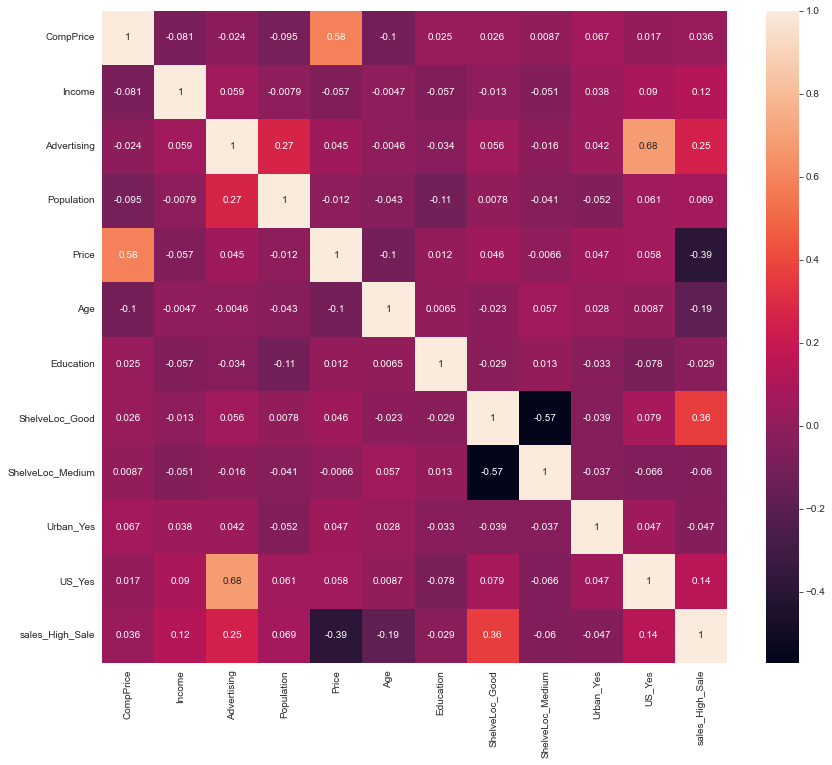

In [14]:
plt.figure(figsize=(14,12))
sns.heatmap(comp_2.corr(), annot=True, cmap='rocket')

### Normalization

In [15]:
def norm_func (i):
    x = (i-i.min())/(i.max()-i.min())
    return (x)

In [16]:
comp_norm = norm_func(comp_2)
comp_norm.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes,sales_High_Sale
0,0.622449,0.525253,0.379310,0.533066,0.574850,0.309091,0.875,0.0,0.0,1.0,1.0,1.0
1,0.346939,0.272727,0.551724,0.501002,0.353293,0.727273,0.000,1.0,0.0,1.0,1.0,1.0
2,0.367347,0.141414,0.344828,0.519038,0.335329,0.618182,0.250,0.0,1.0,1.0,1.0,1.0
3,0.408163,0.797980,0.137931,0.913828,0.437126,0.545455,0.500,0.0,1.0,1.0,1.0,0.0
4,0.653061,0.434343,0.103448,0.661323,0.622754,0.236364,0.375,0.0,0.0,1.0,0.0,0.0


### K-Fold Cross Validation

In [17]:
x = comp_norm.drop(["sales_High_Sale"], axis = 1)
y = comp_norm["sales_High_Sale"]

In [18]:
x.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,0.622449,0.525253,0.379310,0.533066,0.574850,0.309091,0.875,0.0,0.0,1.0,1.0
1,0.346939,0.272727,0.551724,0.501002,0.353293,0.727273,0.000,1.0,0.0,1.0,1.0
2,0.367347,0.141414,0.344828,0.519038,0.335329,0.618182,0.250,0.0,1.0,1.0,1.0
3,0.408163,0.797980,0.137931,0.913828,0.437126,0.545455,0.500,0.0,1.0,1.0,1.0
4,0.653061,0.434343,0.103448,0.661323,0.622754,0.236364,0.375,0.0,0.0,1.0,0.0


In [19]:
y.head()

0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
Name: sales_High_Sale, dtype: float64

In [20]:
kfold = KFold(n_splits=10, shuffle=True)

### Building model using Random Forest

In [21]:
model = RandomForestClassifier(n_estimators=50, max_features=4, random_state=7)
model.fit(x,y)
result = cross_val_score(model, x, y, cv=kfold)
print(result.mean())

0.8


In [22]:
pred = model.predict(x)
pred

array([1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 0., 0., 0.

In [23]:
pd.crosstab(y, pred)

col_0,0.0,1.0
sales_High_Sale,,
0.0,201,0
1.0,0,199


In [24]:
np.mean(pred==y)*100

100.0

### Conclusion
### -> We get the 100% accuracy for this 'Company_Data Dataset' when we prepare the model using Random Forest algorithm.